In [16]:
import numpy as np
import tensorflow as tf
import keras 
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm 
import os
import re

Here we sort data in correct order and then perform data augmentation(creating more photos basing on initial ones):

In [17]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


# defining the size of image 
SIZE = 256

image_path = 'C:/Users/adria/Desktop/studia/6_sem/AI/AE/photos'
img_array = []

sketch_path = 'C:/Users/adria/Desktop/studia/6_sem/AI/AE/sketches'
sketch_array = []

image_file = sorted_alphanumeric(os.listdir(image_path))
sketch_file = sorted_alphanumeric(os.listdir(sketch_path))


for i in tqdm(image_file):
    image = cv2.imread(image_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    
    #appending normal normal image    
    img_array.append(img_to_array(image))
    # Image Augmentation
    
    # horizontal flip 
    img1 = cv2.flip(image,1)
    img_array.append(img_to_array(img1))
     #vertical flip 
    img2 = cv2.flip(image,-1)
    img_array.append(img_to_array(img2))
     #vertical flip 
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    img_array.append(img_to_array(img3))
    # rotate clockwise 
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    img_array.append(img_to_array(img4))
    # flip rotated image 
    img5 = cv2.flip(img4,1)
    img_array.append(img_to_array(img5))
     # rotate anti clockwise 
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img_array.append(img_to_array(img6))
    # flip rotated image 
    img7 = cv2.flip(img6,1)
    img_array.append(img_to_array(img7))
  
    
for i in tqdm(sketch_file):
    image = cv2.imread(sketch_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    # appending normal sketch image
    sketch_array.append(img_to_array(image))
    
    #Image Augmentation
    # horizontal flip 
    img1 = cv2.flip(image,1)
    sketch_array.append(img_to_array(img1))
     #vertical flip 
    img2 = cv2.flip(image,-1)
    sketch_array.append(img_to_array(img2))
     #vertical flip 
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    sketch_array.append(img_to_array(img3))
    # rotate clockwise 
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    sketch_array.append(img_to_array(img4))
    # flip rotated image 
    img5 = cv2.flip(img4,1)
    sketch_array.append(img_to_array(img5))
     # rotate anti clockwise 
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    sketch_array.append(img_to_array(img6))
    # flip rotated image 
    img7 = cv2.flip(img6,1)
    sketch_array.append(img_to_array(img7))

100%|██████████| 188/188 [00:01<00:00, 125.29it/s]


Here we can see number of images after data augmentation:

In [18]:
print("Total number of sketch images:",len(sketch_array))
print("Total number of images:",len(img_array))

Total number of sketch images: 1504
Total number of images: 1504


Plotting original image and sketch next to each other with the use of matplotlib:

In [19]:
# defining function to plot images pair
def plot_images(image, sketches):
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.title('Image', color = 'green', fontsize = 20)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.title('Sketches ', color = 'black', fontsize = 20)
    plt.imshow(sketches)
   
    plt.show()

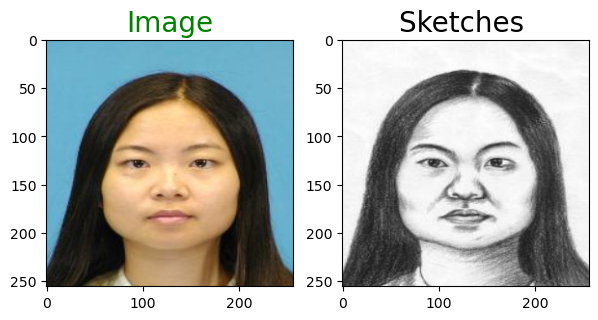

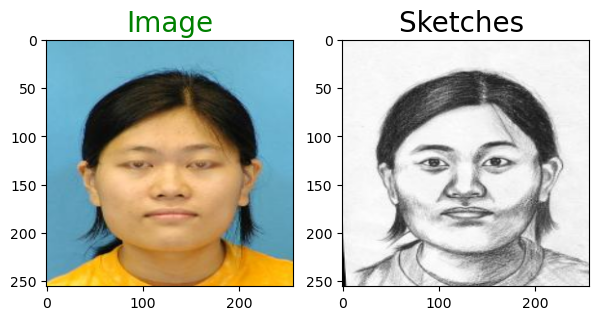

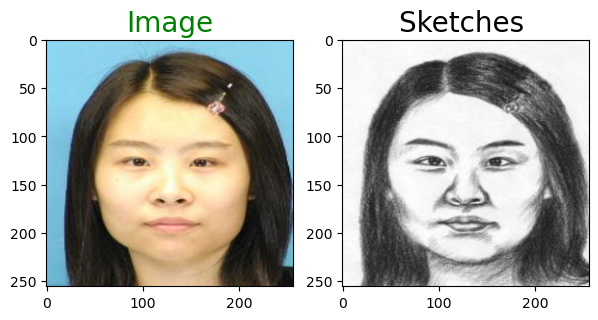

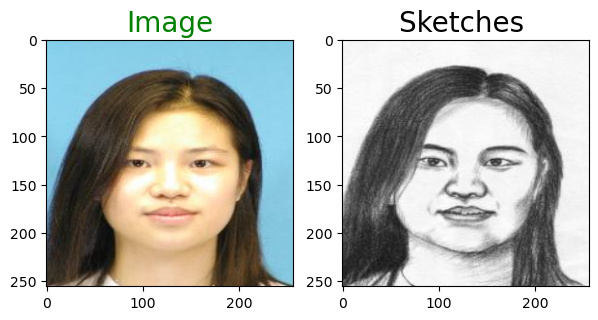

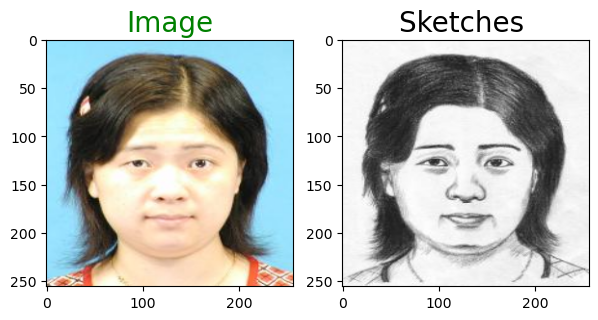

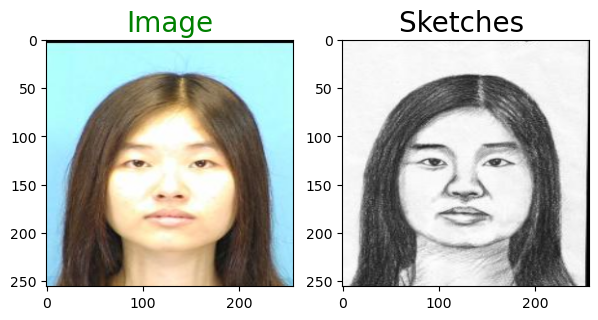

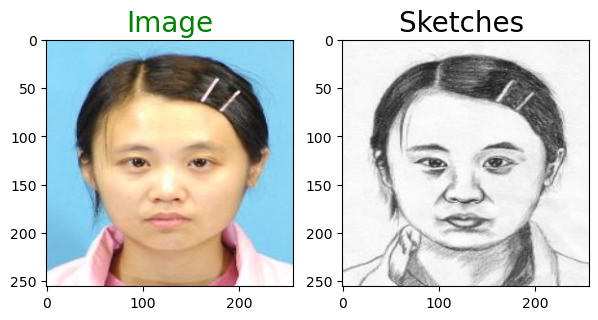

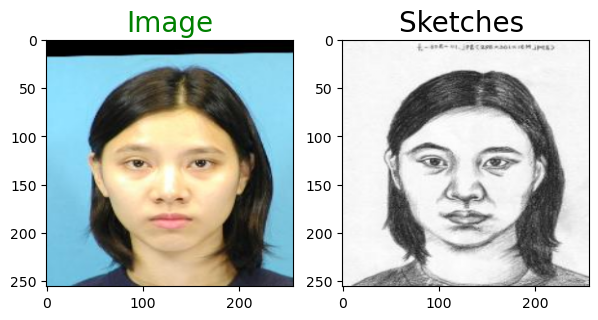

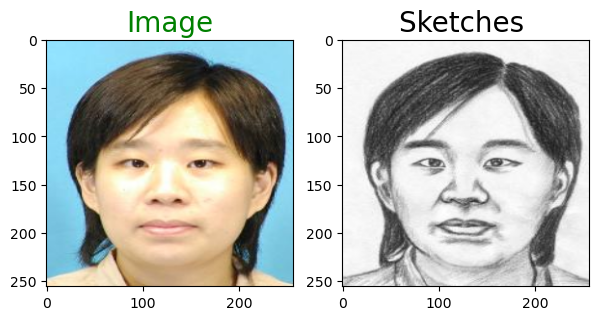

In [20]:
ls = [i for i in range(0,65,8)]
for i in ls:
    plot_images(img_array[i],sketch_array[i])

Dividing our set of photos into train and test data and reshaping:

In [21]:
train_sketch_image = sketch_array[:1400]
train_image = img_array[:1400]
test_sketch_image = sketch_array[1400:]
test_image = img_array[1400:]
# reshaping
train_sketch_image = np.reshape(train_sketch_image,(len(train_sketch_image),SIZE,SIZE,3))
train_image = np.reshape(train_image, (len(train_image),SIZE,SIZE,3))
print('Train color image shape:',train_image.shape)
test_sketch_image = np.reshape(test_sketch_image,(len(test_sketch_image),SIZE,SIZE,3))
test_image = np.reshape(test_image, (len(test_image),SIZE,SIZE,3))
print('Test color image shape',test_image.shape)

Train color image shape: (1400, 256, 256, 3)
Test color image shape (104, 256, 256, 3)


Downsample and upsample functions:

In [22]:
def downsample(filters, size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(keras.layers.Conv2D(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_batch_normalization:
        downsample.add(keras.layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

In [23]:
def upsample(filters, size, apply_dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(keras.layers.Conv2DTranspose(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_dropout:
        upsample.add(tf.keras.layers.Dropout(0.1))
    upsample.add(tf.keras.layers.LeakyReLU()) 
    return upsample

Creating a encoding model which downsample and upsample our data:

In [24]:
def model():
    encoder_input = keras.Input(shape = (SIZE, SIZE, 3))
    x = downsample(16, 4, False)(encoder_input)
    x = downsample(32,4)(x)
    x = downsample(64,4,False)(x)
    x = downsample(128,4)(x)
    x = downsample(256,4)(x)
   
    encoder_output = downsample(512,4)(x)
    
    decoder_input = upsample(512,4,True)(encoder_output)
    x = upsample(256,4,False)(decoder_input)
    x = upsample(128,4, True)(x)
    x = upsample(64,4)(x)
    x = upsample(32,4)(x)
    x = upsample(16,4)(x)
    x = tf.keras.layers.Conv2DTranspose(8,(2,2),strides = (1,1), padding = 'valid')(x)
    decoder_output = tf.keras.layers.Conv2DTranspose(3,(2,2),strides = (1,1), padding = 'valid')(x)
    
  
    return tf.keras.Model(encoder_input, decoder_output)


In [25]:
# to get summary of model
model = model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_12 (Sequential)  (None, 127, 127, 16)      768       
                                                                 
 sequential_13 (Sequential)  (None, 62, 62, 32)        8320      
                                                                 
 sequential_14 (Sequential)  (None, 30, 30, 64)        32768     
                                                                 
 sequential_15 (Sequential)  (None, 14, 14, 128)       131584    
                                                                 
 sequential_16 (Sequential)  (None, 6, 6, 256)         525312    
                                                                 
 sequential_17 (Sequential)  (None, 2, 2, 512)         2099

Testing model with the different number of epochs. Theoretically, the more the better, but running program with big number of epochs can last very long, so we look for the most suitable option:

In [26]:
my_range = range(1,51)
losses = []
accuracies = []
for i in my_range:
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

    model.fit(train_image, train_sketch_image, epochs = i, verbose = 2)
    prediction_on_test_data = model.evaluate(test_image, test_sketch_image)
    losses.append(prediction_on_test_data[0])
    accuracies.append(prediction_on_test_data[1])

44/44 - 68s - loss: 0.3276 - acc: 0.4372 - 68s/epoch - 2s/step
4/4 [==============================] - 3s 298ms/step - loss: 0.5979 - acc: 0.3142
Epoch 1/2
44/44 - 60s - loss: 0.1890 - acc: 0.3637 - 60s/epoch - 1s/step
Epoch 2/2
44/44 - 44s - loss: 0.1326 - acc: 0.3607 - 44s/epoch - 994ms/step
4/4 [==============================] - 2s 233ms/step - loss: 0.1341 - acc: 0.3628
Epoch 1/3
44/44 - 42s - loss: 0.2063 - acc: 0.3550 - 42s/epoch - 962ms/step
Epoch 2/3
44/44 - 39s - loss: 0.1235 - acc: 0.3638 - 39s/epoch - 891ms/step
Epoch 3/3
44/44 - 39s - loss: 0.1134 - acc: 0.3654 - 39s/epoch - 897ms/step
4/4 [==============================] - 3s 211ms/step - loss: 0.1120 - acc: 0.3615
Epoch 1/4
44/44 - 45s - loss: 0.1418 - acc: 0.3652 - 45s/epoch - 1s/step
Epoch 2/4
44/44 - 41s - loss: 0.1071 - acc: 0.3660 - 41s/epoch - 932ms/step
Epoch 3/4
44/44 - 40s - loss: 0.1023 - acc: 0.3719 - 40s/epoch - 919ms/step
Epoch 4/4
44/44 - 39s - loss: 0.0990 - acc: 0.3751 - 39s/epoch - 885ms/step
4/4 [========

In [27]:
print("Loss: ", prediction_on_test_data[0])
print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))

Loss:  0.07723650336265564
Accuracy:  33.7


Displaying images vs sketch vs sketch predicted by model according to highest number of epochs:

In [28]:
def show_images(real,sketch, predicted):
    plt.figure(figsize = (12,12))
    plt.subplot(1,3,1)
    plt.title("Image",fontsize = 15, color = 'Lime')
    plt.imshow(real)
    plt.subplot(1,3,2)
    plt.title("sketch",fontsize = 15, color = 'Blue')
    plt.imshow(sketch)
    plt.subplot(1,3,3)
    plt.title("Predicted",fontsize = 15, color = 'gold')
    plt.imshow(predicted)

1/1 [==============================] - 0s 60ms/step


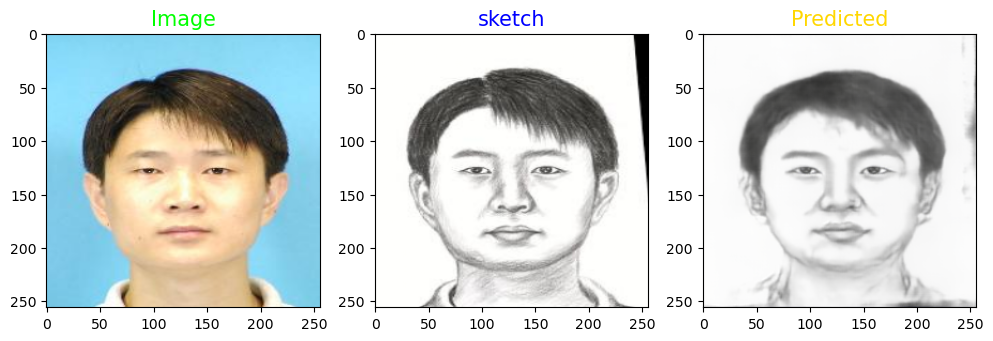

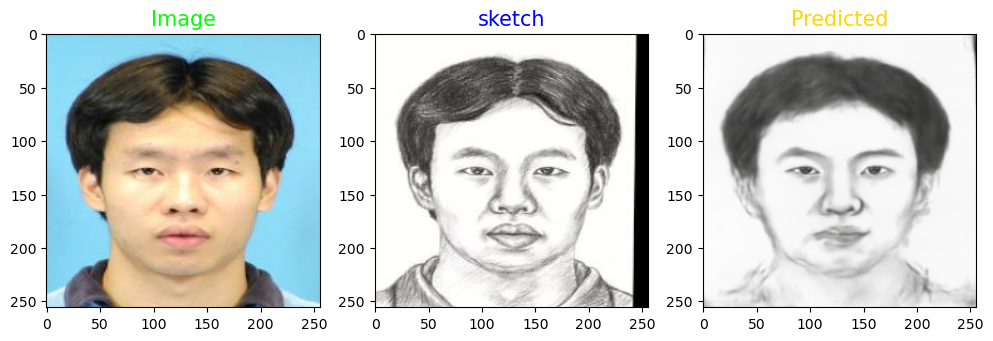

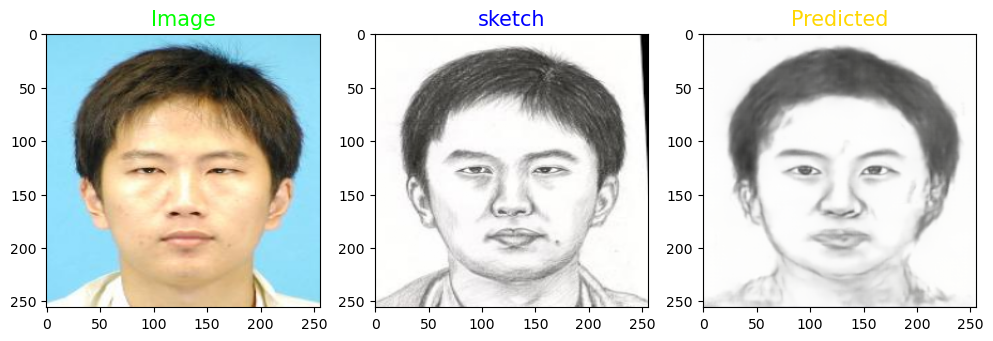

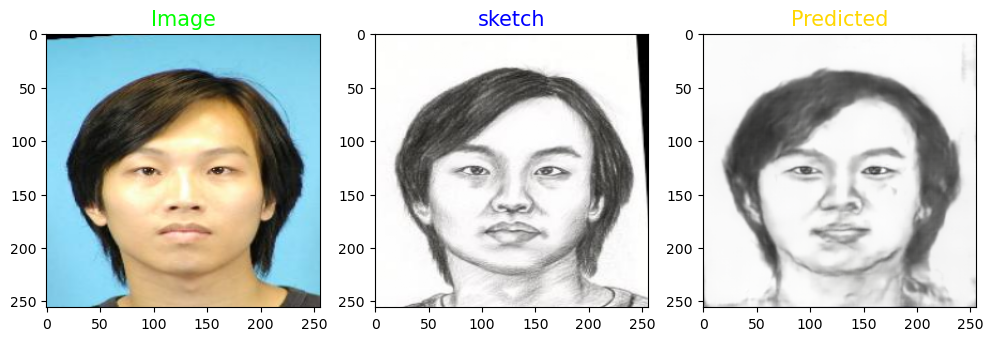

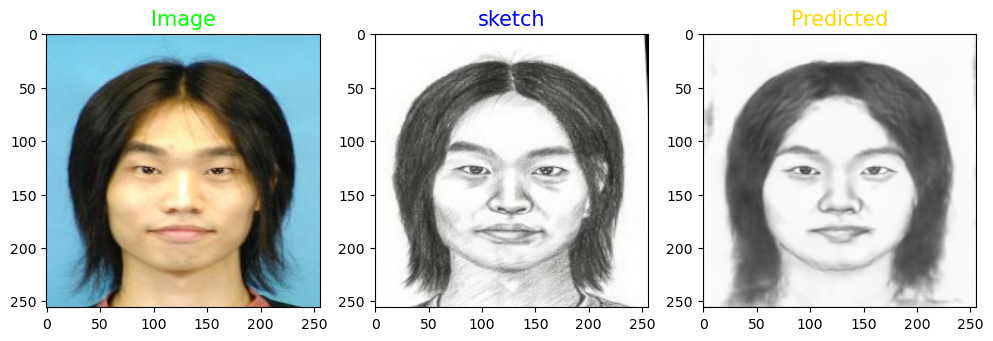

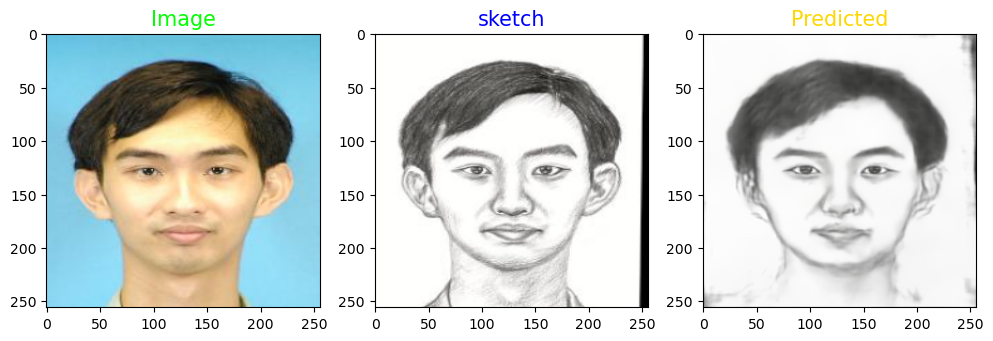

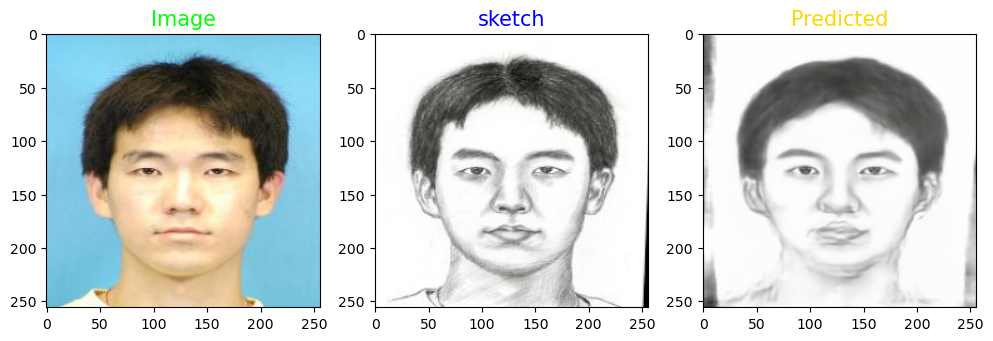

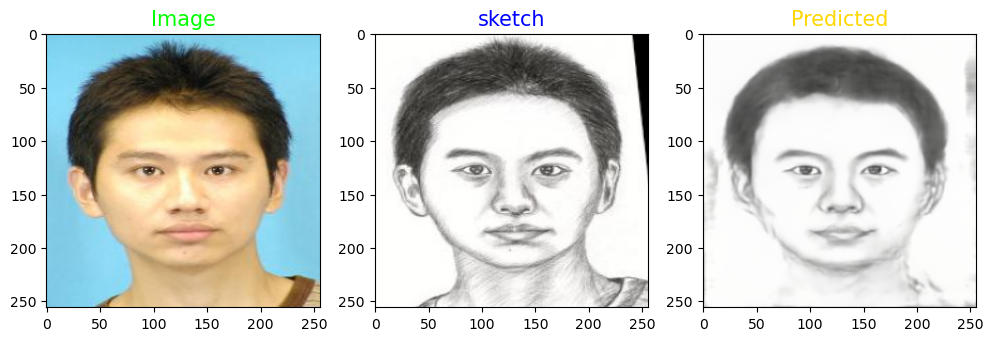

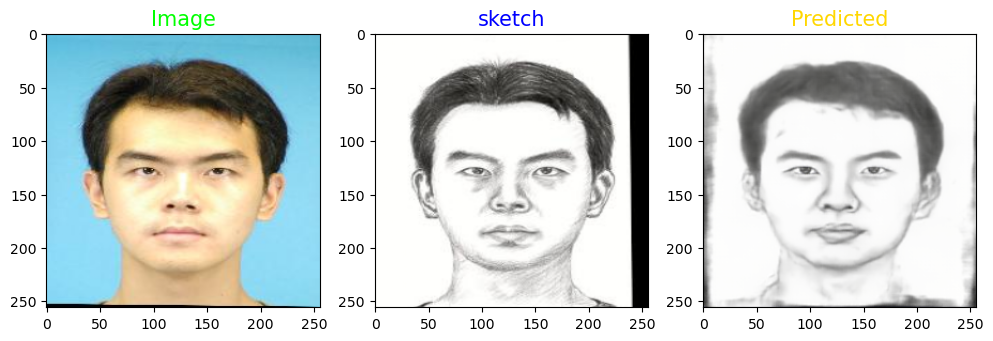

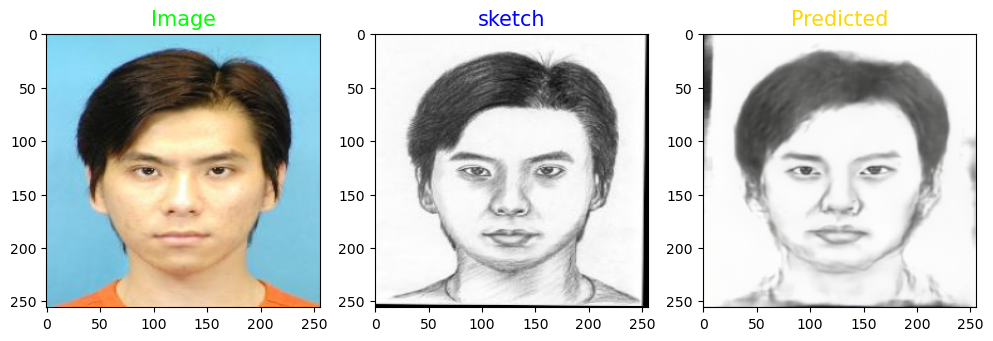

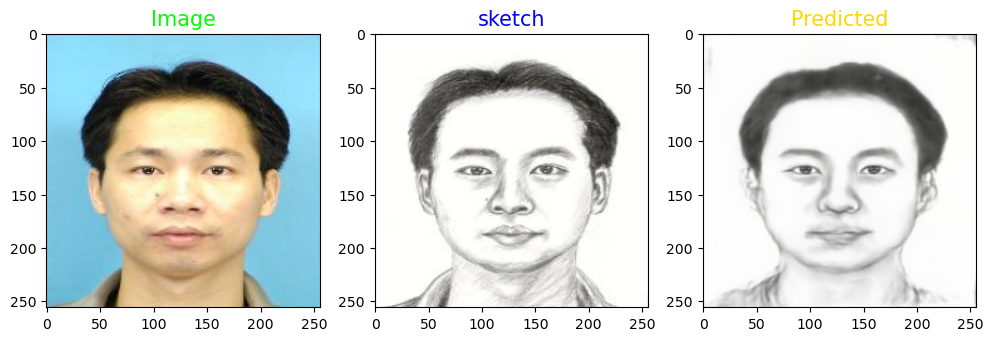

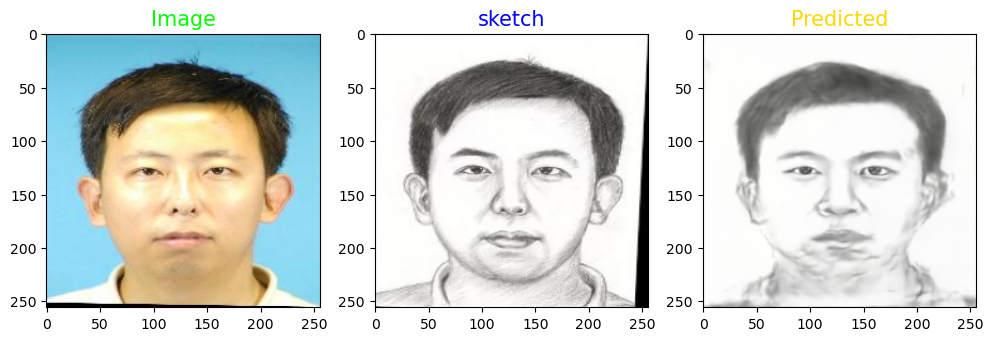

In [29]:
ls = [i for i in range(0,95,8)]
for i in ls:
    predicted =np.clip(model.predict(test_image[i].reshape(1,SIZE,SIZE,3)),0.0,1.0).reshape(SIZE,SIZE,3)
    show_images(test_image[i],test_sketch_image[i],predicted)

Visualisation of how number of epochs relates to loss and accuracy:

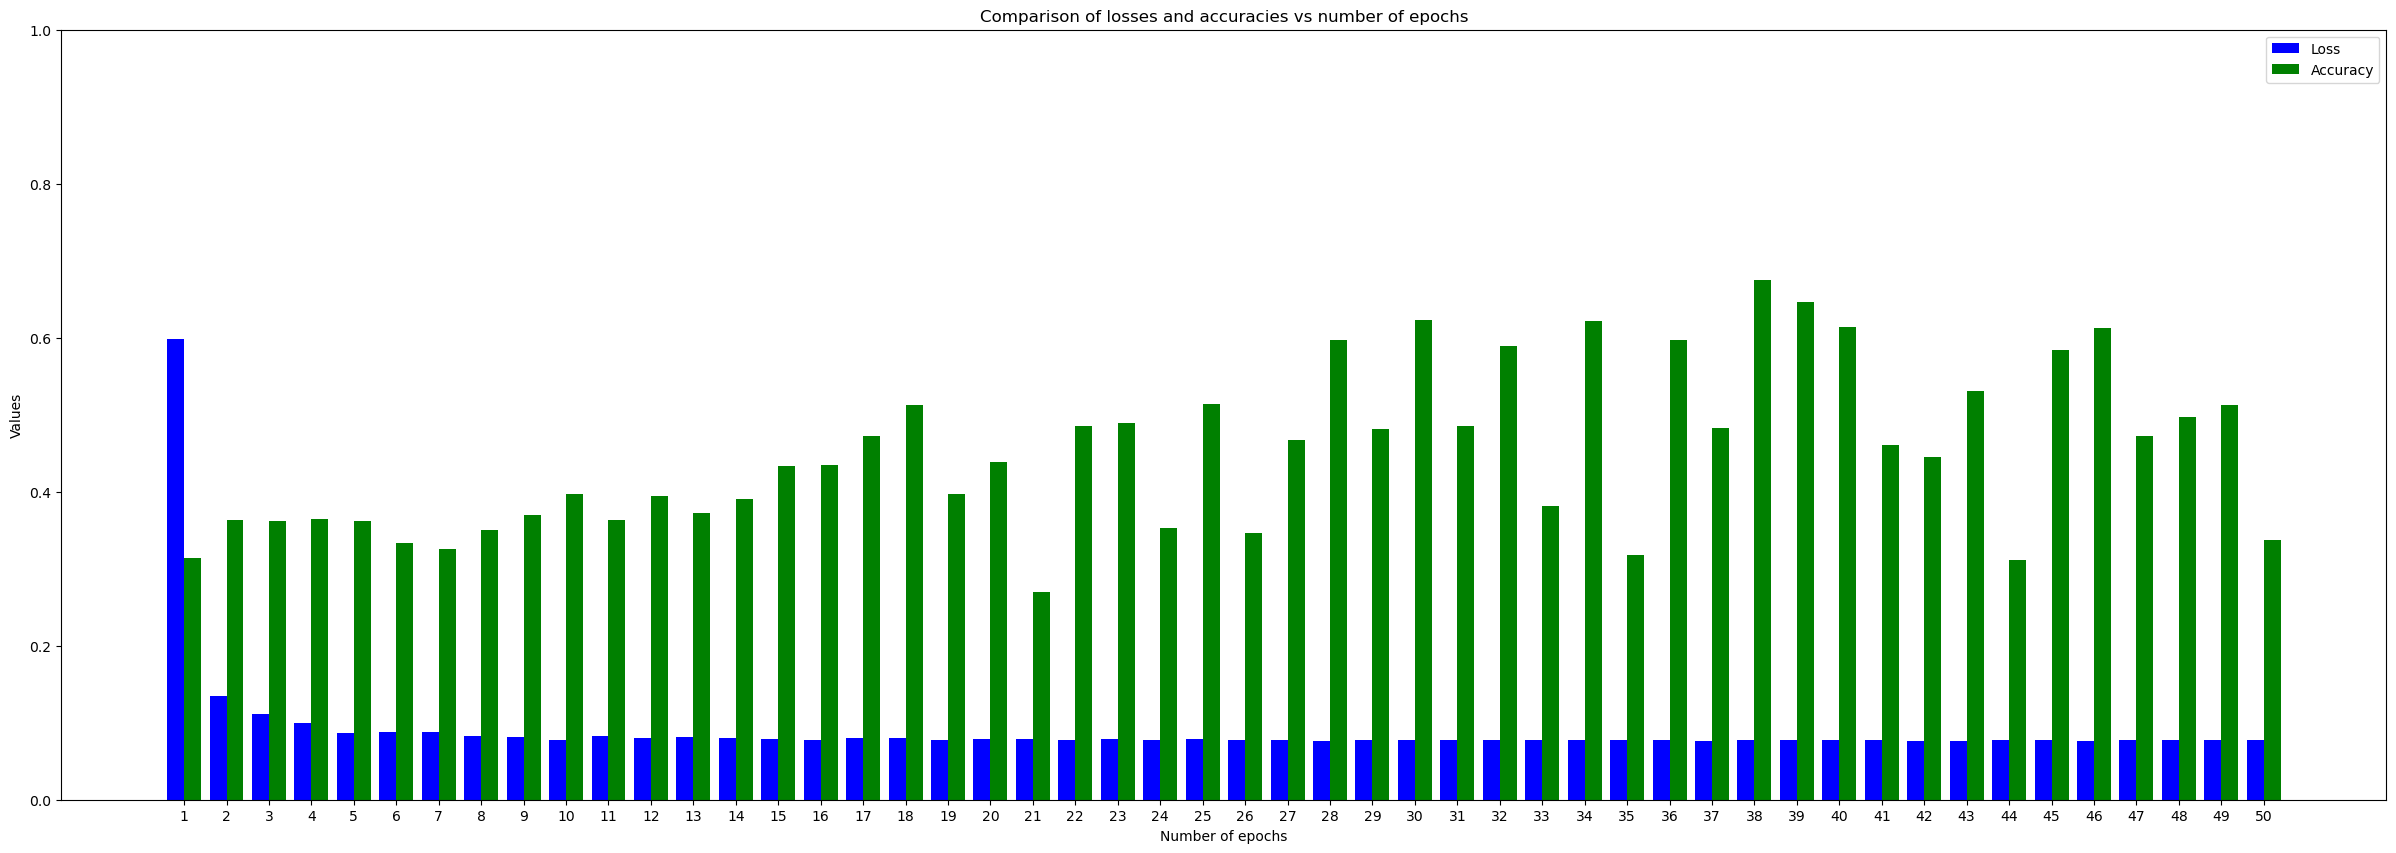

In [31]:
plt.figure(figsize=(30,10))

x_val = [*my_range]
X_axis = np.arange(len(my_range))

plt.bar(X_axis-0.2, losses,0.4 ,color='blue', label = "Loss")
plt.bar(X_axis+0.2, accuracies,0.4, color='green', label = "Accuracy")
plt.ylim(0, 1) 


plt.title('Comparison of losses and accuracies vs number of epochs')

plt.xticks(X_axis, x_val)
plt.xlabel('Number of epochs')
plt.ylabel('Values')

plt.legend()